## MIT License

MIT License

Copyright (c) 2023 Shrenik Porwal, Argy Sakti, Yashish Hirani, Abhi Vachani, Josh Finkelstein

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Welcome to your notebook.


#### Run this cell to connect to your GIS and get started:

In [2]:
from arcgis.gis import GIS
gis = GIS("home")

/opt/conda/lib/python3.9/site-packages/arcgis/gis/__init__.py:703: UserWarning: You are logged on as argysakti with an administrator role, proceed with caution.
  warnings.warn(


## Import the WebMap Data

In [3]:
from arcgis.mapping import WebMap
# Access the Singapore WebMap
web_map_item = gis.content.get('4a5f3f69579f4b7995135d86e98d4156') 

# Create a WebMap object from the web map item
web_map = WebMap(web_map_item)

In [4]:
# Determine the layers that exist in the Web Map
for layer in web_map.layers:
    print(layer.title) 

Sg MRT Stations 
Sg hexes with subway bus count income and area
sg hexes with bus count income and area
Sg Bus Stops 
Sg Pop Density-Copy
Sg POI
Sg Pop Density
sg income 3


## Clean the WebMap Data

In [5]:
from arcgis.features import FeatureLayer
# URL for ..
feature_layer_url = web_map.layers[1].url

# Create a FeatureLayer object
feature_layer = FeatureLayer(feature_layer_url)

# Query the feature layer for specific data
# For example, let's query for all features, retrieving all fields
query_result = feature_layer.query()

# Convert the FeatureSet to a DataFrame
df = query_result.sdf

# t_mmearn_x = median income, h3, population = population NUMPOINTS = num of points of interest, area = area, Num_Bus_St
df = df[['FID', 'MEDIAN_INC', 'h3', 'population', 'area', 'NUMPOINTS', 'num_bus_st', 'num_subway']]
df.head()

,FID,MEDIAN_INC,h3,population,area,NUMPOINTS,num_bus_st,num_subway
0,1,3500,88652636edfffff,8950.0,659467.280597,3.0,3.0,0.0
1,2,3500,88652636ebfffff,21622.0,833875.828359,42.0,17.0,2.0
2,3,3500,88652636e9fffff,5415.0,833819.534926,56.0,4.0,1.0
3,4,3500,88652636e7fffff,5.0,327700.398575,0.0,0.0,0.0
4,5,3500,88652636e5fffff,334.0,477581.443253,1.0,1.0,0.0


## Perform Analysis

In [6]:
import pandas as pd

# weighted median income = Summation ( area i /(total area in hex) ) * t_mmearn_xi 
# Step 1: Group by 'h3_index' and calculate the total area, weighted median income, and total population
grouped = df.groupby('h3').apply(lambda x: pd.Series({
    'total_area': x['area'].sum(),
    'weighted_median_income': (x['area'] / x['area'].sum() * x['MEDIAN_INC']).sum(),
    'population': x['population'].sum(),
    'poi_count': x['NUMPOINTS'].sum(),
    'bus_st_count': x['num_bus_st'].sum(),
    'subway_st_count': x['num_subway'].max()
})).reset_index()

sub_weight = grouped['bus_st_count'].sum() / grouped['subway_st_count'].sum() # Subway weight = total number of bus stations / total number of subway stations
grouped['public_transport_stations'] = grouped['bus_st_count'] + (sub_weight * grouped['subway_st_count'])
grouped = grouped[grouped['weighted_median_income'] != 0]
grouped.head()

,h3,total_area,weighted_median_income,population,poi_count,bus_st_count,subway_st_count,public_transport_stations
66,886520c12dfffff,757980.495632,91.512028,744.0,0.0,1.0,0.0,1.0
90,886520c165fffff,272415.451272,3500.000000,2406.0,0.0,0.0,0.0,0.0
91,886520c167fffff,183884.378843,2614.853374,1635.0,0.0,0.0,0.0,0.0
184,886520c859fffff,834589.851872,9.143456,6.0,0.0,1.0,0.0,1.0
226,886520c969fffff,651028.857921,586.940948,310.0,0.0,2.0,0.0,2.0


In [7]:
grouped.describe()

,total_area,weighted_median_income,population,poi_count,bus_st_count,subway_st_count,public_transport_stations
count,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000
mean,772332.173014,3559.476769,18974.300000,40.858491,8.411321,0.716981,17.032044
std,175170.978153,1605.544310,21238.524189,86.343167,6.669958,1.123345,17.417400
min,2337.571896,0.073853,1.000000,0.000000,0.000000,0.000000,0.000000
25%,833055.859021,3275.013028,2301.250000,3.000000,2.000000,0.000000,3.000000
50%,833579.641729,3500.000000,12506.000000,17.000000,8.000000,0.000000,13.000000
75%,834079.664963,4500.000000,29782.750000,44.750000,13.750000,1.000000,26.023641
max,834675.217166,11500.000000,115524.000000,1048.000000,31.000000,8.000000,125.189125


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = grouped[['weighted_median_income', 'population', 'poi_count', 'public_transport_stations']].corr()
print(correlation_matrix)

                           weighted_median_income  population  poi_count  \
weighted_median_income                   1.000000    0.073587   0.009983   
population                               0.073587    1.000000   0.162076   
poi_count                                0.009983    0.162076   1.000000   
public_transport_stations                0.129678    0.512902   0.525614   

                           public_transport_stations  
weighted_median_income                      0.129678  
population                                  0.512902  
poi_count                                   0.525614  
public_transport_stations                   1.000000  


Coefficients: [0.00037891 0.08946054]
Intercept: 6.219644717234882
Mean Squared Error: 102.11987345329206
R2 Score: 0.44785483403029425


/tmp/ipykernel_188/1983609005.py:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


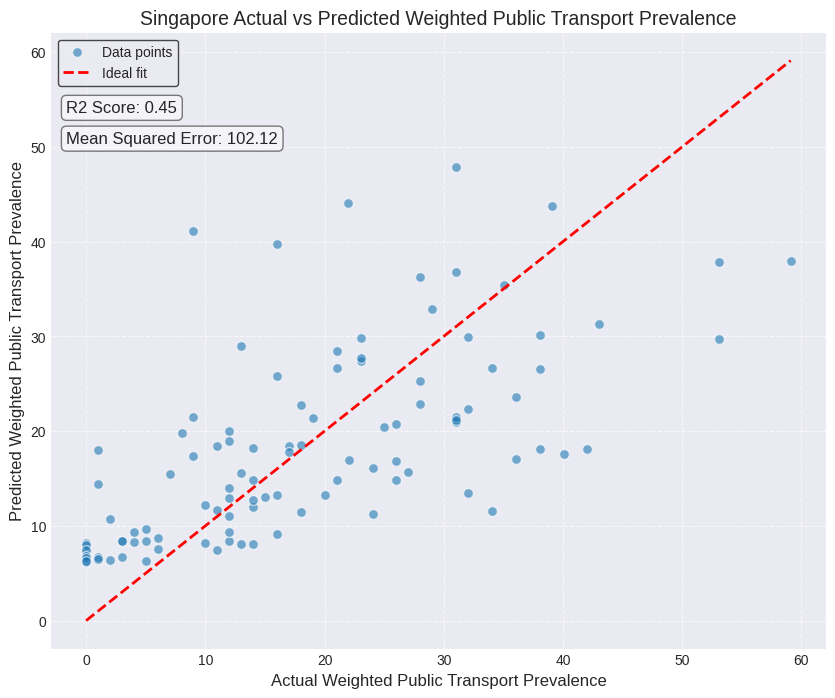

In [12]:
# Now we run a regression of the model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the dataset into training and testing sets
X = grouped[['population','poi_count']]
y = grouped['public_transport_stations']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the population on the testing set
y_pred = regressor.predict(X_test)

# Printing the coefficients and intercept
print(f"Coefficients: {regressor.coef_}")
print(f"Intercept: {regressor.intercept_}")

# Calculating and printing the performance metrics
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2_score(y_test, y_pred)}")

# Visualizing the results
# Ensure that fonts are large enough to read and the plot is a good size
plt.figure(figsize=(10, 8))

# Use a consistent and appealing style
plt.style.use('seaborn-darkgrid')

# Scatter plot with appropriate marker size and edgecolor for better visibility
plt.scatter(y_test, y_pred, label='Data points', alpha=0.6, edgecolors='w', s=50)

# Ideal fit line with clear color
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal fit', linewidth=2)

# Legend with semi-transparent background
legend = plt.legend(frameon=True)
legend.get_frame().set_alpha(0.7)
legend.get_frame().set_edgecolor('black')

# Annotations with buffer space from the edge, larger font size, and a background color for readability
plt.text(0.02, 0.89, f'R2 Score: {r2:.2f}', fontsize=12, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.text(0.02, 0.84, f'Mean Squared Error: {mse:.2f}', fontsize=12, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Axis labels and title with increased font size for better readability
plt.xlabel("Actual Weighted Public Transport Prevalence", fontsize=12)
plt.ylabel("Predicted Weighted Public Transport Prevalence", fontsize=12)
plt.title("Singapore Actual vs Predicted Weighted Public Transport Prevalence", fontsize=14)

# Display the grid lines as a background to the plot
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Export Clean Grouped Dataset to CVS

In [ ]:
from IPython.display import FileLink, display
grouped.to_csv('singapore.csv', index=False)
display(FileLink('singapore.csv'))